Date: 04/13/2025

Author: Nasheed Jafri

Purpose: Modeling risk of Alzheimer's as probabilities instead of raw classification

# Introduction

In this notebook, we move beyond predictive modeling and turn our attention to understanding patterns and relationships within the data through inferential analysis. Specifically, we explore how the presence or absence of certain clinical and behavioral features affects the likelihood of an Alzheimer's diagnosis.

Rather than training a model, our goal here is to derive interpretable, data-driven insights by computing conditional probabilities — such as:

- What is the probability of having Alzheimer’s, given that a patient reports memory complaints?
- How does the risk change if a patient exhibits behavioral problems?

This analysis allows us to:

- Quantify the individual contribution of key symptoms to Alzheimer’s risk,
- Gain transparency into the dataset beyond black-box models,
- Support hypothesis generation and guide clinical focus areas.

By grounding our findings in conditional probability and visual inspection, we aim to enhance interpretability and foster more informed, feature-specific reasoning in the context of Alzheimer’s disease.

# Inferential Analysis for all patients (including patients with memory complaints)

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, RocCurveDisplay

In [7]:
df = pd.read_csv("/Users/nasheedjafri/Downloads/data/kaggle_train.csv")
df = df.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_train, df_test = train_test_split(df, random_state= 123 , shuffle= True,
                                     test_size=0.2, stratify=df['Diagnosis'])

In [95]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}


In [15]:
# Best params from tuning
model_tuned_tree_params = {
    'criterion': 'entropy',
    'max_depth': 2,
    'min_samples_split': 19
}
model_tuned_ada_params = {
    'n_estimators': 130,
    'learning_rate': 0.26971280658002783
}

# Tuned AdaBoost model for the entire dataset
model_tuned_ = AdaBoostClassifier(
    **model_tuned_ada_params,
    estimator=DecisionTreeClassifier(**model_tuned_tree_params, random_state=123),
    random_state=123
)

model_tuned_.fit(df_train[all_features[:-1]], df_train.Diagnosis)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=2,
                                                    min_samples_split=19,
                                                    random_state=123),
                   learning_rate=0.26971280658002783, n_estimators=130,
                   random_state=123)

In [17]:
# Isotonic calibration pipeline
calibrated_model_isotonic = CalibratedClassifierCV(estimator=model_tuned_, method='isotonic', cv=5)
calibrated_model_isotonic.fit(df_train[all_features[:-1]], df_train.Diagnosis)

CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=2,
                                                                                     min_samples_split=19,
                                                                                     random_state=123),
                                                    learning_rate=0.26971280658002783,
                                                    n_estimators=130,
                                                    random_state=123),
                       method='isotonic')

In [19]:
# Predict calibrated probabilities on the test set
calibrated_probs_isotonic = calibrated_model_isotonic.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk'] = calibrated_probs_isotonic
df_test[['Diagnosis', 'alzheimers_risk']].head()

,Diagnosis,alzheimers_risk
486,0,0.039643
397,1,0.818700
1339,1,0.983333
1311,0,0.041628
236,0,0.051037


In [21]:
def assign_risk_group(prob):
    if prob < 0.33:
        return 'Low'
    elif prob < 0.66:
        return 'Medium'
    else:
        return 'High'

In [23]:
# Apply to the test set
df_test['risk_group'] = df_test['alzheimers_risk'].apply(assign_risk_group)
df_test[['Diagnosis', 'alzheimers_risk', 'risk_group']].head()

,Diagnosis,alzheimers_risk,risk_group
486,0,0.039643,Low
397,1,0.818700,High
1339,1,0.983333,High
1311,0,0.041628,Low
236,0,0.051037,Low


In [25]:
important_features = ['MMSE', 'FunctionalAssessment', 'ADL', 
                      'MemoryComplaints', 'BehavioralProblems', 'CholesterolHDL']

Of these, MemoryComplaints and BehavioralProblems are binary features.

## Binary Features

In [31]:
# Using empirical proportions (frequencies) of actual diagnosis outcomes within each group of the binary feature

binary_features = ['MemoryComplaints', 'BehavioralProblems']

for feature in binary_features:
    print(f"\n--- Conditional Alzheimer’s Probability: {feature} ---")
    display(pd.crosstab(df_test[feature], df_test['Diagnosis'], normalize='index').round(3))


--- Conditional Alzheimer’s Probability: MemoryComplaints ---


Diagnosis,0,1
MemoryComplaints,,
0,0.715,0.285
1,0.386,0.614



--- Conditional Alzheimer’s Probability: BehavioralProblems ---


Diagnosis,0,1
BehavioralProblems,,
0,0.702,0.298
1,0.364,0.636


**Interpretation:** The above tables show $P(\text{Diagnosis}|\text{Feature})$.

- Patients who report memory complaints have more than double the Alzheimer’s risk (61.4%) compared to those who don’t (28.5%). This aligns strongly with clinical expectations — memory complaints are often one of the earliest red flags.

- Presence of behavioral problems also more than doubles the probability of Alzheimer's diagnosis (63.6% vs 29.8%) — likely pointing to the neuropsychiatric aspects of the disease.

Both features are strong conditional indicators of Alzheimer’s, possibly useful for early screening.

In [37]:
# Using calibrated risk of Alzheimer's

for feature in binary_features:
    print(f"\n--- Average Calibrated Risk by {feature} ---")
    display(df_test.groupby(feature)['alzheimers_risk'].mean().round(3))


--- Average Calibrated Risk by MemoryComplaints ---


MemoryComplaints
0    0.281
1    0.599
Name: alzheimers_risk, dtype: float64


--- Average Calibrated Risk by BehavioralProblems ---


BehavioralProblems
0    0.302
1    0.575
Name: alzheimers_risk, dtype: float64

**Interpretation:** The above tables show $\mathbb{E}[\text{Modeled Risk of Alzheimer's}|\text{Feature}]$.

- Our calibrated model gives an expected Alzheimer's risk of 59.9% for patients who report memory complaints, which is again about twice as compared to those who don’t (28.1%). 

- Similarly, our model expects an Alzheimer's risk of 57.5% for patients who exhibit behavioral problems, which is again about twice as compared to those who don’t (30.2%). 

The results are very close to the ones observed using frequentist proportions. This shows that our calibrated model is well-aligned with the empirical truth, which is desirable in medical contexts like Alzheimer's prediction.

**Conclusion:**

- Our model is thus capturing the clinical signal from binary symptoms well.
- Calibration curves and Brier scores you calculated earlier back this up quantitatively.


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/316344594.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


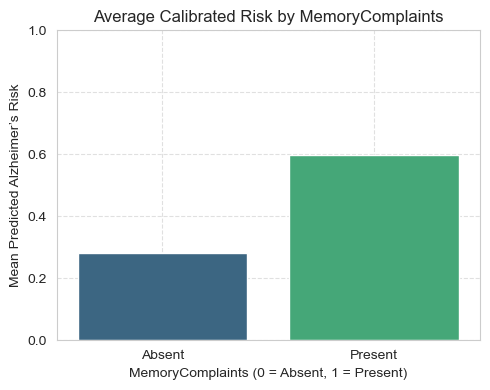

/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/316344594.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


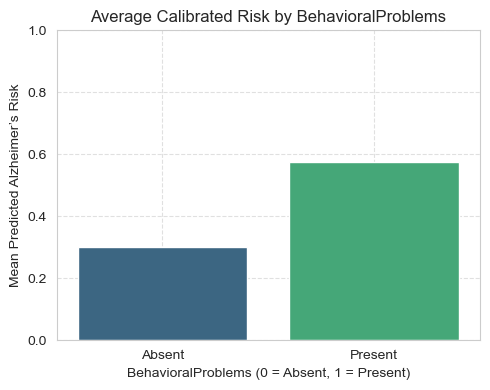

In [68]:
for feature in binary_features:
    plt.figure(figsize=(5, 4))
    sns.barplot(
        data=df_test,
        x=feature,
        y='alzheimers_risk',
        estimator='mean',
        errorbar=None,
        palette='viridis'
    )
    plt.title(f'Average Calibrated Risk by {feature}')
    plt.xlabel(f'{feature} (0 = Absent, 1 = Present)')
    plt.ylabel('Mean Predicted Alzheimer’s Risk')
    plt.ylim(0, 1)
    plt.xticks([0, 1], ['Absent', 'Present'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## Continuous Features

In [52]:
# Define binned columns
binned_features = {
    'MMSE': 'MMSE_bin',
    'FunctionalAssessment': 'FA_bin',
    'ADL': 'ADL_bin',
    'CholesterolHDL': 'Cholesterol_bin'
}

# Create quantile-based bins
df_test['MMSE_bin'] = pd.qcut(df_test['MMSE'], q=3, labels=['Low', 'Medium', 'High'])
df_test['FA_bin'] = pd.qcut(df_test['FunctionalAssessment'], q=3, labels=['Low', 'Medium', 'High'])
df_test['ADL_bin'] = pd.qcut(df_test['ADL'], q=3, labels=['Low', 'Medium', 'High'])
df_test['Cholesterol_bin'] = pd.qcut(df_test['CholesterolHDL'], q=3, labels=['Low', 'Medium', 'High'])

# Loop through features and show both empirical and model-based risk
for feature, bin_col in binned_features.items():
    print(f"\n📊 {feature} — Empirical vs Calibrated Risk")
    
    # Empirical: observed diagnosis proportion (Diagnosis = 1)
    empirical = pd.crosstab(df_test[bin_col], df_test['Diagnosis'], normalize='index')[1].rename('Empirical')
    
    # Model-based: mean predicted risk
    model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')

    comparison = pd.concat([empirical, model], axis=1).round(3)
    display(comparison)


📊 MMSE — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/2787642089.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
MMSE_bin,,
Low,0.417,0.389
Medium,0.447,0.434
High,0.191,0.216



📊 FunctionalAssessment — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/2787642089.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
FA_bin,,
Low,0.557,0.565
Medium,0.368,0.375
High,0.130,0.098



📊 ADL — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/2787642089.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
ADL_bin,,
Low,0.591,0.589
Medium,0.289,0.278
High,0.174,0.170



📊 CholesterolHDL — Empirical vs Calibrated Risk


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/2787642089.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model = df_test.groupby(bin_col)['alzheimers_risk'].mean().rename('Model')


,Empirical,Model
Cholesterol_bin,,
Low,0.313,0.334
Medium,0.395,0.375
High,0.348,0.329


**Interpretation for the effect of MMSE (Mini-Mental State Examination) on Alzheimer's risk:**

- Patients in the High MMSE group (i.e., higher cognitive function) have the lowest Alzheimer’s risk both empirically and by the model — as expected.
- The Medium group has slightly higher risk than the Low group, which may suggest:
- Some non-linear effects (e.g., mild cognitive impairment doesn’t always progress to AD).

**Interpretation for the effect of Functional Assessment on Alzheimer's risk:**

- Strong, clear decreasing trend — lower FA (i.e., more impairment) → higher Alzheimer’s risk.
- The model is extremely well-calibrated here. It not only matches the pattern, but also the exact risk levels almost perfectly.
- Suggests FA is a robust and reliable predictor in our model and in real-world patient data.

**Interpretation for the effect of ADL (Activities of Daily Living) on Alzheimer's risk:**

- Again, a clear inverse relationship — more difficulty with daily tasks (lower ADL score) → higher risk of Alzheimer’s.
- Model risk aligns nearly identically with empirical risk.
- Confirms that functional independence is a strong marker of cognitive decline in this population.

**Interpretation for the effect of Cholesterol (HDL) on Alzheimer's risk:**

- Unlike MMSE, FA, or ADL, this doesn’t show a strong monotonic trend.
- Medium HDL levels are associated with the highest Alzheimer’s risk, both empirically and in model predictions, not very insightful biologically.
- The model captures the general shape of the trend, though with slightly less separation between bins than in the empirical data.

This is not surprising, as CholesterolHDL was the least important feature among the features we considered.

In [66]:
# Check if the bins are balanced

for col in ['MMSE_bin', 'FA_bin', 'ADL_bin', 'Cholesterol_bin']:
    print(f"\n{col} value counts:")
    print(df_test[col].value_counts(dropna=False))


MMSE_bin value counts:
MMSE_bin
Low       115
High      115
Medium    114
Name: count, dtype: int64

FA_bin value counts:
FA_bin
Low       115
High      115
Medium    114
Name: count, dtype: int64

ADL_bin value counts:
ADL_bin
High      115
Low       115
Medium    114
Name: count, dtype: int64

Cholesterol_bin value counts:
Cholesterol_bin
High      115
Low       115
Medium    114
Name: count, dtype: int64


/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/833539469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


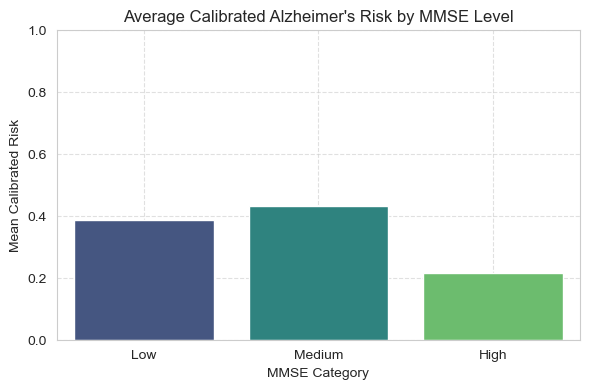

/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/833539469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


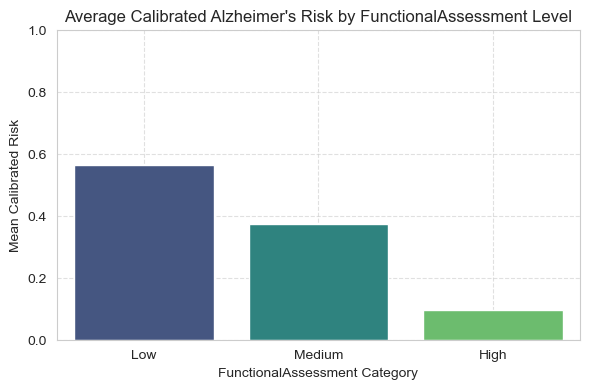

/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/833539469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


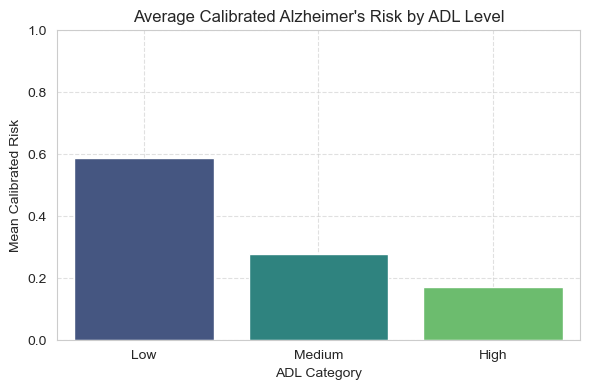

/var/folders/8l/7v02b0mj1798rggrw61wc88m0000gn/T/ipykernel_25996/833539469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


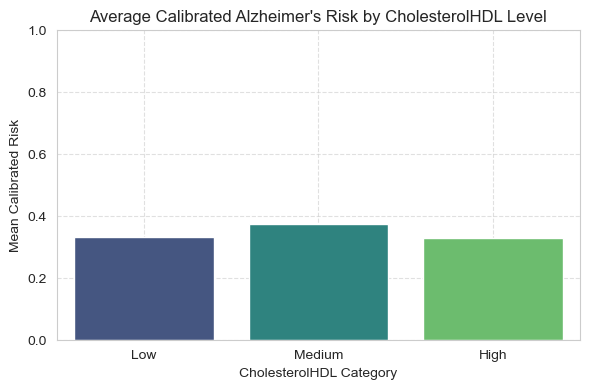

In [64]:
for binned_col, original_feature in binned_features.items():
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=df_test,
        x=binned_col,
        y='alzheimers_risk',
        estimator='mean',
        errorbar=None,
        order=['Low', 'Medium', 'High'],
        hue_order=None,
        palette='viridis'
    )
    plt.title(f'Average Calibrated Alzheimer\'s Risk by {original_feature} Level')
    plt.xlabel(f'{original_feature} Category')
    plt.ylabel('Mean Calibrated Risk')
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## Compare averages of features across risk groups

In [70]:
df_test.groupby('risk_group')[['MMSE', 'FunctionalAssessment', 'ADL']].mean().round(2)

,MMSE,FunctionalAssessment,ADL
risk_group,,,
High,11.15,3.16,3.40
Low,15.69,5.96,5.96
Medium,16.22,6.19,3.72


In [72]:
df_test.groupby('risk_group')[['MemoryComplaints', 'BehavioralProblems']].mean().round(2)

,MemoryComplaints,BehavioralProblems
risk_group,,
High,0.38,0.26
Low,0.12,0.09
Medium,0.27,0.64


## Hidden High-Risk Patients

In [78]:
# Find patients who were not diagnosed with Alzheimer’s, but have high predicted risk
high_risk_undiagnosed = df_test[(df_test['Diagnosis'] == 0) & (df_test['alzheimers_risk'] > 0.66)]
high_risk_undiagnosed.shape

(4, 39)

In [80]:
df_test.shape

(344, 39)

**Note:** 4 individuals out of 344 in the test set have not been diagnosed with Alzheimer’s (Diagnosis = 0), but have high model-predicted risk (alzheimers_risk > 0.66).

That’s only about 1.16% of our test set.

## Risk Distribution across Demographics or Lifestyle Features

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


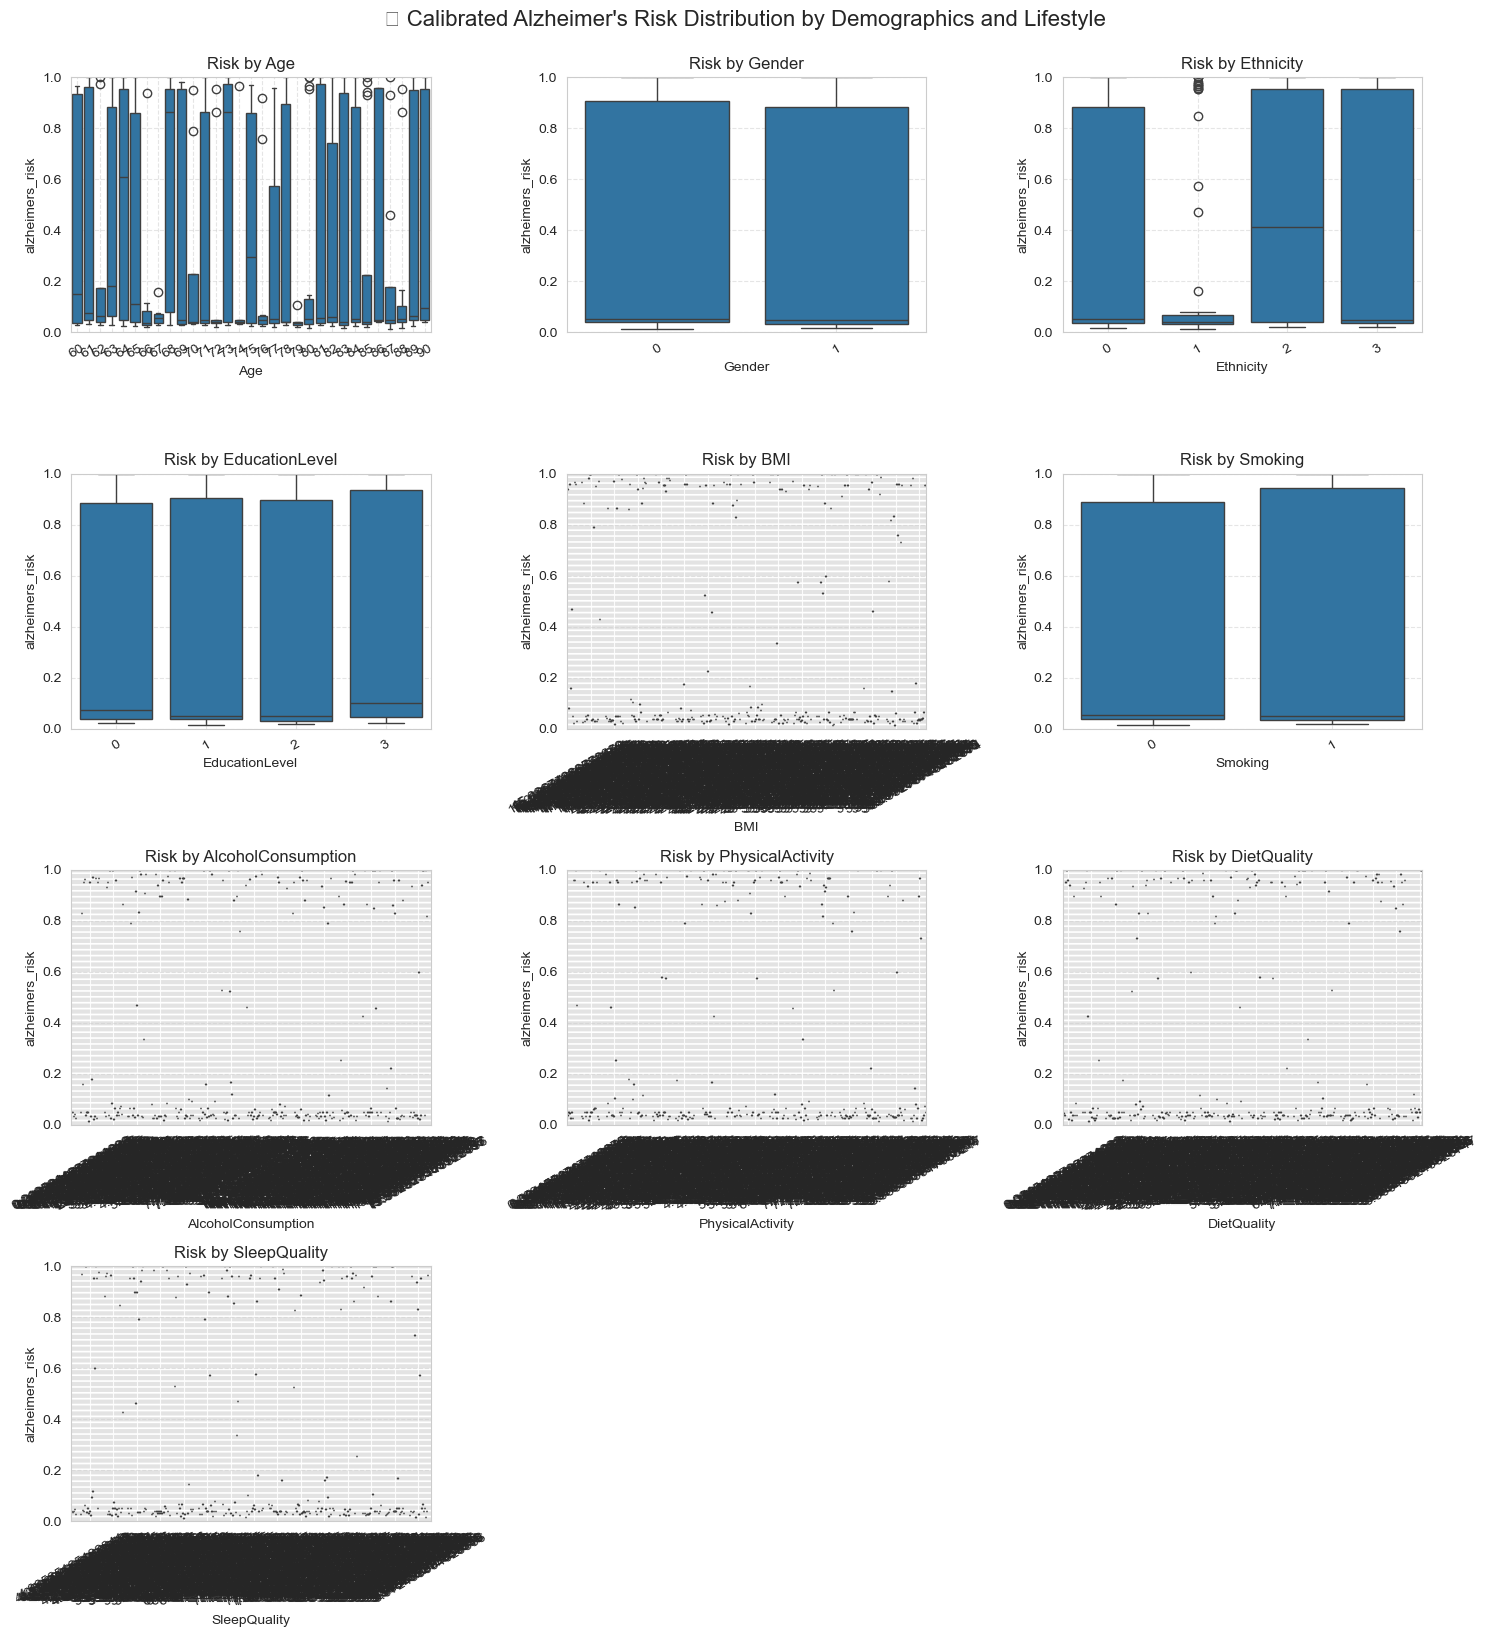

In [97]:
features_to_plot = demo_features[:-1] + life_style_features[:-1]

n_cols = 3
n_rows = -(-len(features_to_plot) // n_cols) 
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.boxplot(x=feature, y='alzheimers_risk', data=df_test)
    plt.title(f'Risk by {feature}')
    plt.ylim(0, 1)
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("📊 Calibrated Alzheimer's Risk Distribution by Demographics and Lifestyle", fontsize=16, y=1.02)
plt.show()